### TRABAJO PRACTICO Nº3
Integrantes:
- Maria Victoria Teran
- Fernando Vasconcelos
- Lara Rosenberg

In [1]:
#Importamos las librerias necesarias
import cv2 as cv
import numpy as np
%matplotlib inline  
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
#Path de las imagenes
path_template = 'IMAGENES/template.png'

list_path_images = ['IMAGENES/coca_logo_1.png',
 'IMAGENES/coca_logo_2.png',
 'IMAGENES/coca_multi.png',
 'IMAGENES/coca_retro_1.png',
 'IMAGENES/coca_retro_2.png',
 'IMAGENES/COCA-COLA-LOGO.jpg',
 'IMAGENES/logo_1.png']


RECORTAMOS EL TEMPLATE: 

Observamos que el template tiene bordes totalmente blancos que no influyen en el logo en si, y para obtener una mejor precisión decidimos eliminarlos.

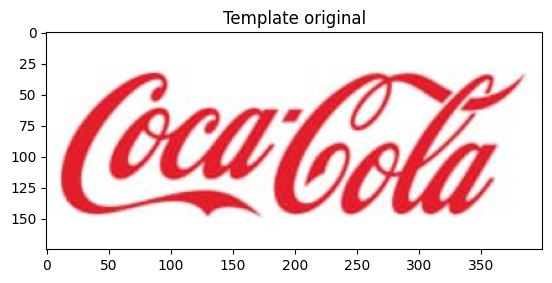

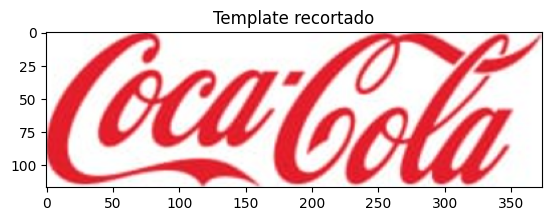

In [3]:
# Cargamos la imagen original  
temp = cv.imread(path_template)  

# Convertimos la imagen a escala de grises  
gray_image = cv.cvtColor(temp, cv.COLOR_BGR2GRAY)  

# Aplicamos el detector de bordes Canny  
edges = cv.Canny(gray_image, 100, 200)  

# Creamos una máscara para eliminar filas completamente negras (cero)  
row_mask = np.any(edges != 0, axis=1)  
edges_row_filtered = edges[row_mask]   
final_result_tmp = gray_image[row_mask]  

# Creamos una máscara para eliminar columnas completamente negras (cero)  
col_mask = np.any(edges_row_filtered != 0, axis=0)  

# Recortamos la imagen original  
recorte = temp [row_mask][:, col_mask] 

# Guardamos la imagen para su posterior uso 
cv.imwrite('template_recortado.png', recorte)  

# Mostramos el template original
plt.imshow(cv.cvtColor(temp, cv.COLOR_BGR2RGB))  
plt.title('Template original')  
plt.show() 

# Mostramos el template recortado
plt.imshow(cv.cvtColor(recorte, cv.COLOR_BGR2RGB))  
plt.title('Template recortado')  
plt.show()  

#### PUNTO 1: Obtener una detección del logo en cada imagen sin falsos positivos

Planteamos una función que reciba como input: el template, la imagen y escala del template. Y nos devuelve un bounding box con el logo y el nivel de confianza utilizando la métrica TM_CCOEFF_NORMED.

In [4]:
def deteccion_logo_unico(path_imagen, path_template, per_scale):  
    # Cargamos y procesamos la imagen  
    img = cv.imread(path_imagen)  
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  
    
    # Desenfocamos la imagen con el objetivo de eliminar ruido
    blurred = cv.GaussianBlur(img_gray, (5, 5), 0)  
    
    # Aplicamos el detector de bordes de Canny  
    edges = cv.Canny(blurred, 150, 200) 
    
    # Cargamos y procesamos el template
    template = cv.imread(path_template)  
    template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    
    # Calculamos el nuevo ancho y alto del template  
    ancho, alto = int(template.shape[1] * per_scale), int(template.shape[0] * per_scale)  
    
    # Aplicamos un ligero desenfoque antes de redimensionar  
    template_blurred = cv.GaussianBlur(template, (5, 5), 0)  

    # Aplicamos el detector de bordes de Canny  
    template_edges = cv.Canny(template_blurred, 150, 200) 
    
    # Redimensionamos la plantilla usando interpolación   
    templates_resize_1 = cv.resize(template_edges, (ancho, alto), interpolation=cv.INTER_AREA)  

    w, h = templates_resize_1.shape[::-1]  
    
    img_salida = img.copy()  
    
    # Aplicamos la coincidencia de patrones  
    res = cv.matchTemplate(edges, templates_resize_1, eval('cv.TM_CCOEFF_NORMED'))  
    
    # Encontramos los valores máximos y mínimos  
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)  

    print('CONFIANZA EN LA DETECCION: ', max_val)
    
    # Tomamos el máximo   
    top_left = max_loc  
    
    # Marcamos el lugar donde lo haya encontrado  
    bottom_right = (top_left[0] + w, top_left[1] + h)  
    cv.rectangle(img_salida, top_left, bottom_right, 255, 2)  

    img_salida_rgb = cv.cvtColor(img_salida, cv.COLOR_BGR2RGB) 
    
    # Graficamos el procesamiento y la salida  
    plt.figure()  
    
    # Mostramos la coincidencia  
    plt.subplot(121), plt.imshow(res, cmap='gray')  
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])  
    
    # Imagen original con recuadros  
    plt.subplot(122), plt.imshow(img_salida_rgb)  
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])  
    
    plt.suptitle('TM_CCOEFF_NORMED - IMAGEN: {}'.format(path_imagen))  
    plt.show()  

CONFIANZA EN LA DETECCION:  0.1101728156208992


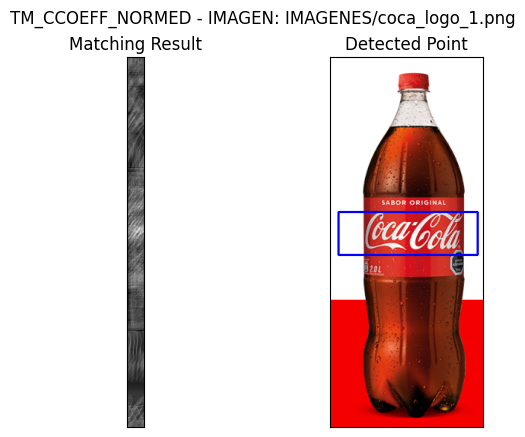

CONFIANZA EN LA DETECCION:  0.0994490310549736


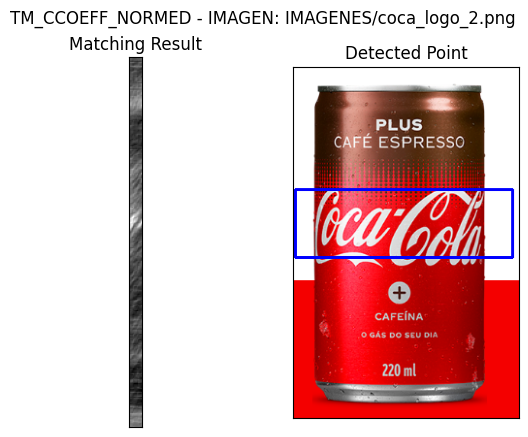

CONFIANZA EN LA DETECCION:  0.19607366621494293


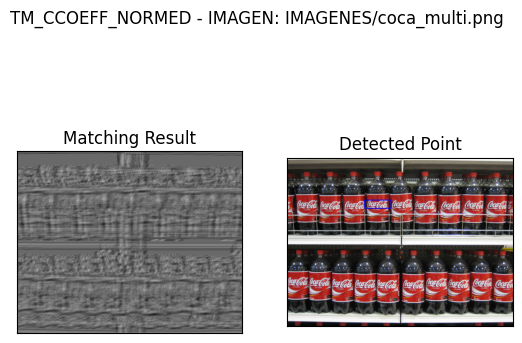

CONFIANZA EN LA DETECCION:  0.06943836808204651


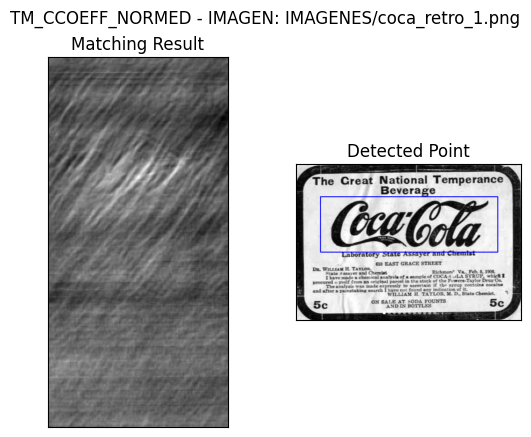

CONFIANZA EN LA DETECCION:  0.08940554410219193


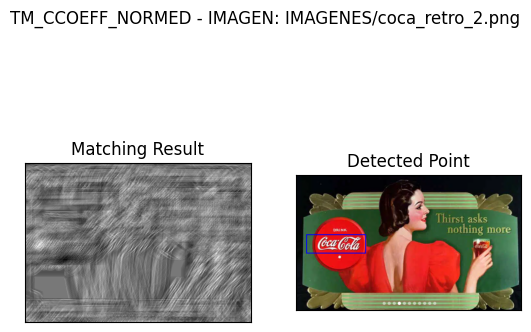

CONFIANZA EN LA DETECCION:  0.034070879220962524


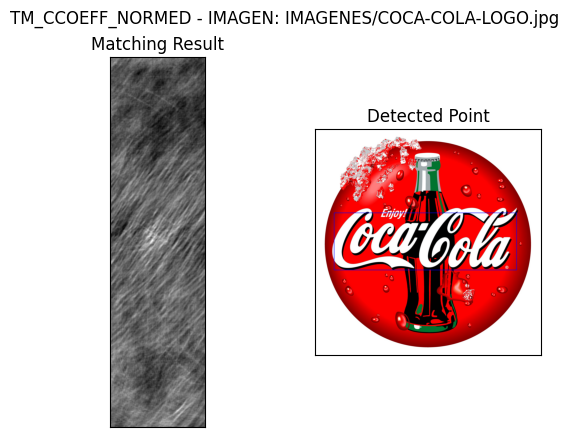

CONFIANZA EN LA DETECCION:  0.10711681097745895


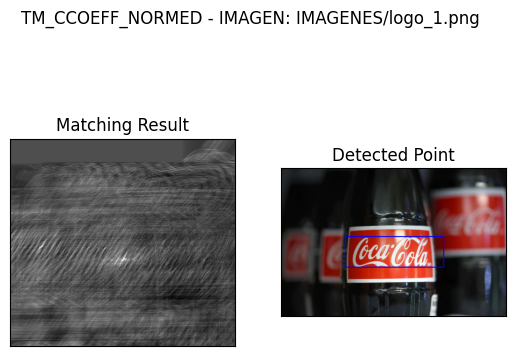

In [5]:
deteccion_logo_unico('IMAGENES/coca_logo_1.png', 'template_recortado.png', 0.5)
deteccion_logo_unico('IMAGENES/coca_logo_2.png', 'template_recortado.png', 0.6)
deteccion_logo_unico('IMAGENES/coca_multi.png', 'template_recortado.png', 0.25)
deteccion_logo_unico('IMAGENES/coca_retro_1.png', 'template_recortado.png', 1.5)
deteccion_logo_unico('IMAGENES/coca_retro_2.png', 'template_recortado.png', 0.5)
deteccion_logo_unico('IMAGENES/COCA-COLA-LOGO.jpg', 'template_recortado.png', 3)
deteccion_logo_unico('IMAGENES/logo_1.png', 'template_recortado.png', 0.8)

Planteamos una función que reciba como input: el template, la imagen, el tamaño del template (chico, mediano y grande) y los métodos para competir (sólo normalizados). Y nos devuelve un bounding box con el logo, el nivel de confianza y la métrica ganadora.

In [6]:
def deteccion_logo_unico2(path_imagen, path_template, matching_methods, rango='mediano'):
    # Cargamos la imagen de entrada  
    img = cv.imread(path_imagen)  
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  
    
    # Preprocesamos la imagen con ruido  
    img_blurred = cv.medianBlur(img_gray, 5)  
    img_canny = cv.Canny(img_blurred, 300, 400)
    
    # Creamos variables para almacenar la mejor coincidencia  
    best_match_value = None  
    best_top_left = None  
    best_bottom_right = None  
    best_method = None  
    best_resized_template = None  

    # Definimos los rangos de escalas para redimensionar el template
    if rango == 'chico':
        scales = np.arange(0.20, 0.45, 0.05) 
    elif rango == 'mediano':
        scales = np.arange(0.5, 1.3, 0.05)
    else:
        scales = np.arange(1.35, 3.25, 0.05)
    
    df = pd.DataFrame(columns=['scale', 'method', 'value']) 

    # Cargamos y procesamos el template
    template = cv.imread(path_template)  
    template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    
    # Aplicamos un ligero desenfoque antes de redimensionar y el detector de bordes de Canny
    template_blurred = cv.GaussianBlur(template, (5, 5), 0)  
    template_edges = cv.Canny(template_blurred, 150, 200) 

    for scale in scales:  
        # Redimensionamos el template  
        ancho, alto = int(template_edges.shape[1] * scale), int(template_edges.shape[0] * scale)  
        resized_template = cv.resize(template_edges, (ancho, alto), interpolation=cv.INTER_AREA)  
        template_height, template_width = resized_template.shape[:2]  

        # Solo continua si el template redimensionado entra en la imagen  
        if template_height >= img.shape[0] or template_width >= img.shape[1]:  
            continue  

        for matching_method in matching_methods:
            # Calculamos la metrica de coincidencia de template  
            result = cv.matchTemplate(img_canny, resized_template, eval(matching_method)) 
            
            # Ajustamos resultados para métodos de coincidencia  
            if matching_method == 'cv.TM_SQDIFF_NORMED':
                min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)  
                match_val = 1- min_val  
                loc = min_loc
            else:  
                min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)  
                match_val = max_val  
                loc = max_loc  

            df.loc[df.shape[0]] = [scale, matching_method, match_val]  

            # Actualizamos si se encuentra una mejor coincidencia  
            if best_match_value is None or (match_val > best_match_value):  
                best_match_value = match_val  
                best_top_left = loc  
                best_bottom_right = (loc[0] + template_width, loc[1] + template_height)  
                best_method = matching_method  
                best_resized_template = resized_template
            
    # Dibujamos rectángulo si se encontró una coincidencia  
    if best_top_left is not None:  
        cv.rectangle(img, best_top_left, best_bottom_right, (255, 0, 0), 2)  
        print(f'Valor de confianza: {best_match_value} usando {best_method}')   
    else:  
        print("No se encontró el logo en la imagen.")  
    
    # Mostramos las imágenes  
    plt.figure(figsize=(10, 5))   
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))  
    plt.title('Imagen con Logo Detectado')  
    plt.axis('off')  
    plt.show()  

Valor de confianza: 0.24187563359737396 usando cv.TM_CCORR_NORMED


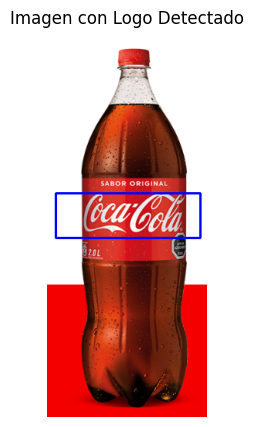

Valor de confianza: 0.23751896619796753 usando cv.TM_CCORR_NORMED


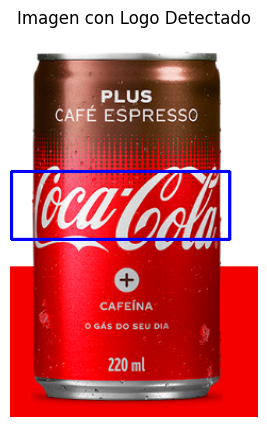

Valor de confianza: 0.3466954231262207 usando cv.TM_CCORR_NORMED


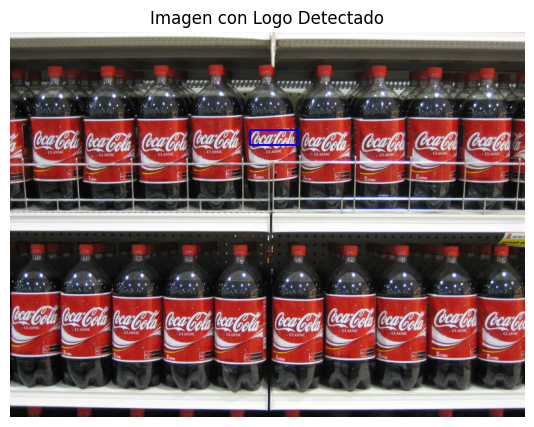

Valor de confianza: 0.19934912025928497 usando cv.TM_CCORR_NORMED


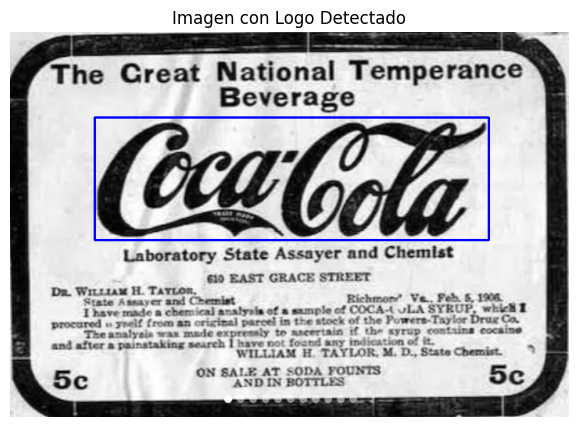

Valor de confianza: 0.21147842705249786 usando cv.TM_CCORR_NORMED


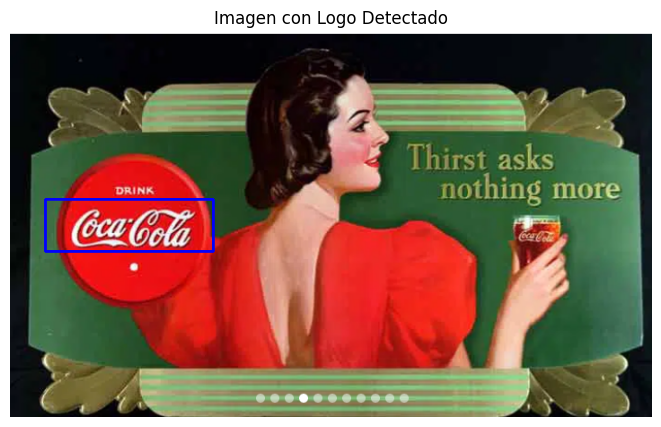

Valor de confianza: 0.12717027962207794 usando cv.TM_CCORR_NORMED


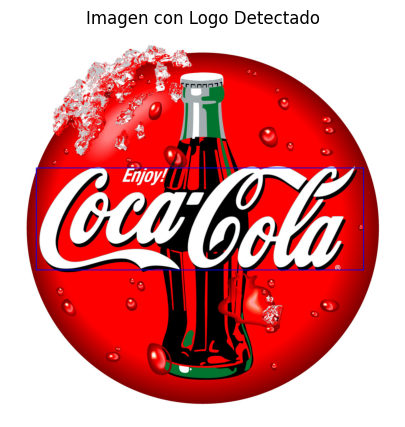

Valor de confianza: 0.23349159955978394 usando cv.TM_CCORR_NORMED


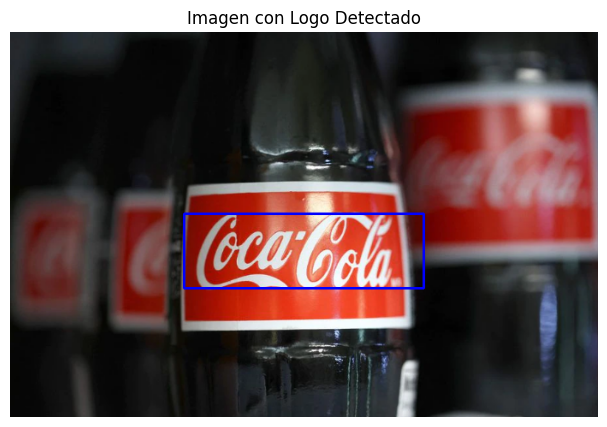

In [7]:
matching_methods = ['cv.TM_SQDIFF_NORMED',  'cv.TM_CCORR_NORMED','cv.TM_SQDIFF_NORMED']
deteccion_logo_unico2('IMAGENES/coca_logo_1.png', 'template_recortado.png',matching_methods, 'mediano')
deteccion_logo_unico2('IMAGENES/coca_logo_2.png', 'template_recortado.png', matching_methods, 'mediano')
deteccion_logo_unico2('IMAGENES/coca_multi.png', 'template_recortado.png', matching_methods,'chico')
deteccion_logo_unico2('IMAGENES/coca_retro_1.png', 'template_recortado.png',matching_methods, 'grande')
deteccion_logo_unico2('IMAGENES/coca_retro_2.png', 'template_recortado.png', matching_methods,'mediano')
deteccion_logo_unico2('IMAGENES/COCA-COLA-LOGO.jpg', 'template_recortado.png',matching_methods, 'grande')
deteccion_logo_unico2('IMAGENES/logo_1.png', 'template_recortado.png', matching_methods, 'mediano')

#### PUNTO 2: Plantear y validar un algoritmo para múltiples detecciones en la imagen

In [8]:
def deteccion_multiple(path_imagen, path_template, matching_method, per_scale, threshold, nms_threshold):
    # Cargamos y procesamos la imagen  
    img = cv.imread(path_imagen)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  
    
    # Desenfocamos la imagen con el objetivo de eliminar ruido
    blurred = cv.GaussianBlur(img_gray, (5, 5), 0)  
    
    # Aplicamos el detector de bordes de Canny  
    edges = cv.Canny(blurred, 150, 200) 
    
    # Cargamos y procesamos el template
    template = cv.imread(path_template)  
    template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    
    # Calculamos el ancho y el alto para hacer el resize del template
    ancho, alto = int(template.shape[1] * per_scale), int(template.shape[0] * per_scale)  
    
    # Aplicamos un ligero desenfoque antes de redimensionar  
    template_blurred = cv.GaussianBlur(template, (5, 5), 0)  

    # Aplicamos el detector de bordes de Canny  
    template_edges = cv.Canny(template_blurred, 150, 200) 
    
    # Redimensionamos el template usando interpolación   
    templates_resize_1 = cv.resize(template_edges, (ancho, alto), interpolation=cv.INTER_AREA)  

    w, h = templates_resize_1.shape[::-1]  
    
    img_salida = img.copy()  
    
    # Calculamos la metrica de coincidencia de template y nos quedamos con aquellos que superan el threshold establecido
    res = cv.matchTemplate(edges, templates_resize_1, eval(matching_method))  
    loc = np.where(res >= threshold)
    
    # Creamos una lista de las coordenadas de los rectángulos a dibujar
    boxes = []
    for pt in zip(*loc[::-1]):
        boxes.append((pt[0], pt[1], pt[0] + w, pt[1] + h))  # (x1, y1, x2, y2)

    # Usamos una lista de confianza de 1 para cada detección
    confidences = [1] * len(boxes)

    # Aplicamos Non-Maximum Suppression
    indices = cv.dnn.NMSBoxes(boxes, confidences, 0.7, nms_threshold)  

    # Verificamos si hay índices y dibujamos solo los rectángulos seleccionados
    if len(indices) > 0: 
        drawn_boxes = set()  
        for i in indices.flatten(): 
            x1, y1, x2, y2 = boxes[i]  

            # Verificamos si el rectángulo ya fue dibujado
            if not any((x1, y1, x2, y2) in drawn_boxes for box in drawn_boxes):
                cv.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 0, 255), 2)
                drawn_boxes.add((x1, y1, x2, y2))  

    # Mostramos la imagen resultante
    plt.imshow(img_rgb) 
    plt.axis('off') 
    plt.show()

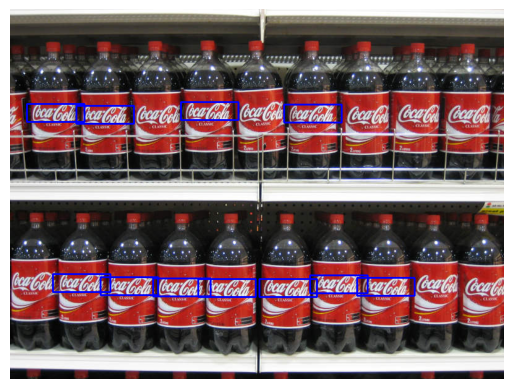

In [9]:
deteccion_multiple('IMAGENES/coca_multi.png', 'template_recortado.png', 'cv.TM_CCOEFF_NORMED', 0.25, 0.13, 0.7)

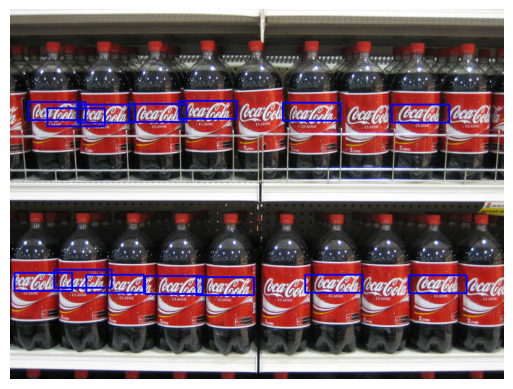

In [10]:
deteccion_multiple('IMAGENES/coca_multi.png', 'template_recortado.png', 'cv.TM_CCORR_NORMED', 0.25, 0.34, 0.5)

#### PUNTO 3: Generalizar el algoritmo del item 2 para todas las imágenes.

In [11]:
def deteccion_multiple_gen(path_imagen, path_template, matching_method, scale_range, threshold, nms_threshold):
    # Cargamos y procesamos la imagen  
    img = cv.imread(path_imagen)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  
    
    # Desenfocamos la imagen con el objetivo de eliminar ruido
    blurred = cv.GaussianBlur(img_gray, (5, 5), 0)  
    
    # Aplicamos el detector de bordes de Canny  
    edges = cv.Canny(blurred, 150, 200) 
    
    # Cargamos y procesamos el template
    template = cv.imread(path_template)  
    template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    
    # Listas para almacenar los bounding boxes
    boxes = []

    # Iteramos a través de los rangos de escala
    for scale in np.arange(scale_range[0], scale_range[1], scale_range[2]):
        # Calculamos el ancho y el alto para aplicar el resize al template
        ancho, alto = int(template.shape[1] * scale), int(template.shape[0] * scale)
        
        # Aplicamos un ligero desenfoque antes de redimensionar y la deteccion de bordes de Canny 
        template_blurred = cv.GaussianBlur(template, (5, 5), 0)  
        template_edges = cv.Canny(template_blurred, 150, 200) 
        
        # Redimensionamos el template usando interpolación
        templates_resize = cv.resize(template_edges, (ancho, alto), interpolation=cv.INTER_AREA)  
        w, h = templates_resize.shape[::-1]  

        # Calculamos la metrica de coincidencia de template y nos quedamos con aquellos que superan el threshold establecido
        res = cv.matchTemplate(edges, templates_resize, eval(matching_method))  
        loc = np.where(res >= threshold)

        # Creamos una lista de las coordenadas de los rectángulos a dibujar
        for pt in zip(*loc[::-1]):
            boxes.append((pt[0], pt[1], pt[0] + w, pt[1] + h))  # (x1, y1, x2, y2)

    # Usamos una lista de confianza de 1 para cada detección
    confidences = [1] * len(boxes)

    # Aplicamos Non-Maximum Suppression
    indices = cv.dnn.NMSBoxes(boxes, confidences, 0.7, nms_threshold)

    # Verificamos si hay índices y dibujamos solo los rectángulos seleccionados
    if len(indices) > 0:  
        for i in indices.flatten():  
            x1, y1, x2, y2 = boxes[i]
            cv.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Mostramos la imagen resultante
    plt.imshow(img_rgb) 
    plt.axis('off') 
    plt.show()

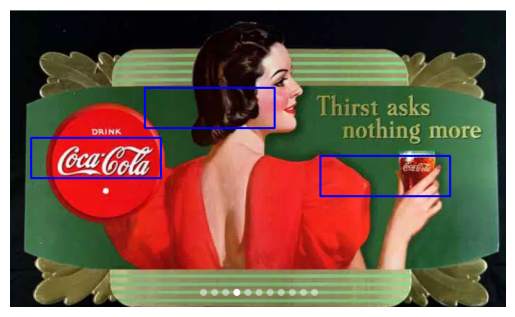

In [12]:
scale_range = (0.50, 1.50, 0.1) 
deteccion_multiple_gen('IMAGENES/coca_retro_2.png', 'template_recortado.png', 'cv.TM_CCOEFF_NORMED', scale_range, 0.08, 0.3)

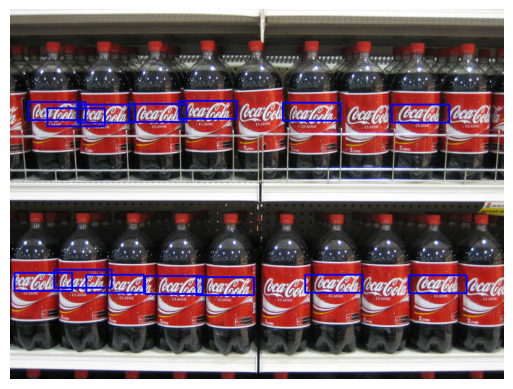

In [13]:
scale_range = (0.25, 0.35, 0.1)
deteccion_multiple_gen('IMAGENES/coca_multi.png', 'template_recortado.png', 'cv.TM_CCORR_NORMED', scale_range, 0.34, 0.5)